# DEAP - Enabling Nimbler Evolutions
by François-Michel De Rainville, Félix-Antoine Fortin, Marc-André Gardner, Marc Parizeau, and Christian Gagné

<img src="files/images/deap_highlights.png" width="400px" style="float:right;margin-left:50px;"/>

DEAP is a Distributed Evolutionary Algorithm (EA) framework written in Python and designed to help researchers developing custom evolutionary algorithms. Its design philosophy promotes explicit algorithms and transparent data structures, in contrast with most other evolutionary computation softwares that tend to encapsulate standardized algorithms using the black-box approach. This philosophy sets it apart as a rapid prototyping framework for testing of new ideas in EA research.

## Introduction

The [DEAP framework](#deap-jmlr) is designed over the three following founding principles:

1. Data structures are key to evolutionary computation. They must facilitate the implementation of algorithms and be easy to customize.
2. Operator selection and algorithm parameters have strong influences on evolutions, while often being problem dependent. Users should be able to parametrize every aspect of the algorithms with minimal complexity.
3. EAs are usually embarrassingly parallel. Therefore, mechanisms that implement distribution paradigms should be trivial to use.

With the help of its sister project [SCOOP](#scoop) and the power of the Python programming language, DEAP implements these three principles in a simple and elegant design.

### Data Structures

A very important part of the success for designing any algorithm - if not the most important - is choosing the appropriate data structures. Freedom in type creation is fundamental in the process of designing evolutionary algorithms that solve real world problems. DEAP's *creator* module allows users to:

- create classes with a single line of code (inheritance);
- add attributes (composition);
- group classes in a single module (sandboxing).

In the following listing, we create a minimizing fitness.


In [1]:
from deap import base, creator
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

The `create` function expects at least two arguments; the name of the class to be created and the base class it inherits from. The next arguments are used as class attributes.
Thus, the class just created is a `FitnessMin` inheriting from the base class `Fitness` and having a `weights` attribute set to the one element tuple `(-1.0,)`, indicating minimization of a single objective. A multi-objective fitness would be created using a multi-element tuple.

Next, we define with the same mechanism an `Individual` class inheriting from a `list` and composed with a `fitness` attribute.

In [2]:
creator.create("Individual", list, fitness=creator.FitnessMin)

When an `Individual` is instantiated, its `fitness` is initialized with an instance of the previously defined `FitnessMin` class. This is illustrated in the following example,

In [3]:
ind = creator.Individual([1,0,1,0,1])
ind.fitness.values = (sum(ind),)

where an individual is created from a list of binary values and the value of its fitness is set to the sum of its elements.
In DEAP, the fitness value is always multi-objective with the single objective case being a tuple of one element. This tuple is instantiated by the comma following the sum operation.

### Operators

Operator selection is another crucial part of evolutionary algorithms. It must be straightforward and its parametrization intuitive. DEAP's *Toolbox* enables users to:

- create aliases for operators;
- register operators' parameters;
- interchange operators efficiently;
- regroup all operators in a single structure.

The next example presents the construction of a toolbox and how operators and their parameters are registered.

In [5]:
from deap import tools
toolbox = base.Toolbox()
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, std=1.0)

The `register` function expects at least two arguments; the alias of the function and the function itself. The next arguments are passed to the function when called, similarly to the `partial` function from the standard *functools* module.
Thus, the first operator is a one point crossover registered under the alias `mate`. The second operator, a gaussian mutation, is registered with its parameters under the generic name `mutate`.  Both operators are available from the *tools* module along with many more instruments to support evolution presented at the end of this paper.

During subsequent experiments, replacing the one point crossover by a two point crossover is as easy as substituting the third line of the previous listing by the following one.

In [12]:
toolbox.register("mate", tools.cxTwoPoint)

Wherever the generic function `mate` is used, the new two point crossover will be used.

### Parallelization
DEAP is parallel ready. The idea is to use a mapping operation that applies a function to every item of a sequence, for instance to evaluate the individuals fitness. By default, every toolbox is registered with the standard `map` function of Python. For algorithms to evaluate individuals in parallel, one only needs to replace this alias by a parallel map such as the one provided by [SCOOP](#scoop), a library capable of distributing tasks over a cluster of computers.

In [14]:
from scoop import futures
toolbox.register("map", futures.map)

DEAP is also compatible with the *multiprocessing* standard module, if the user only cares to run on a single multicore machine.

In [6]:
import multiprocessing
pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

With these powerful tools, DEAP allows scientists and researchers with little programming knowledge to easily implement distributed and parallel EAs.

## Preaching by Example

The best introduction to evolutionary computation with DEAP is to present simple, yet compelling examples. The following sections set forth how algorithms are easy to implement while keeping a strong grip on how they behave. The first section introduces a classical genetic algorithm and exposes different levels of explicitness. The second section presents how genetic programming is implemented in DEAP and the versatility of the GP module. The final example demonstrate how easy it is to implement a generic distributed island model with SCOOP.

### A Simple Genetic Algorithm
A commonly used example in evolutionary computation is the OneMax problem which consists in maximizing the number of ones in a binary solution. The more ones an individual contains, the higher its fitness value is. Using a genetic algorithm to find such an individual is relatively straightforward. Applying crossovers and mutations on a population of randomly generated binary individuals and selecting the fittest ones at each generation usually lead quickly to a perfect (all ones) solution. A problem of this simplicity should be solved with a very simple program.

In [7]:
import random
from deap import algorithms, base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evalOneMax(individual):
    return (sum(individual),)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    pop = toolbox.population(n=300)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False)
    print(tools.selBest(pop, k=1))

/home/kumamon/.conda/envs/dev/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


The preceeding code presents all that is needed to solve the OneMax problem with DEAP. The first two lines import the necessary modules. Next, on lines 3 and 4, two types are created; a maximizing fitness (note the positive weights), and a list individual composed with an instance of this maximizing fitness. Then, on lines 5 and 6, the evaluation function is defined. It counts the number of ones in a binary list by summing its elements (note again the one element returned tuple corresponding to a single objective fitness). Subsequently, a `Toolbox` is instantiated in which the necessary operators are registered. The first operator, on line 8, produces binary values, in this case integers in [0, 1]$, using the standard *random* module. The alias `individual`, on line 9, is assigned to the helper function `initRepeat`, which takes a container as the first argument, a function that generates content as the second argument and the number of repetitions as the last argument.
Thus, calling the individual function instantiates an `Individual` of `n=100` bits by calling repeatedly the registered `attr_bool` function. The same repetition initializer is used on the next line to produce a population as a list of individuals. The missing number of repetition `n` will be given later in the program. Subsequently, on lines 11 to 14, the evaluation, crossover, mutation and selection operators are registered with all of their parameters.

The main program starts at line 16. First, a population of `n=300` individuals is instantiated. Then, the algorithm, provided with the population and the toolbox, is run for `ngen=40` generations with `cxpb=0.5` probability of mating and `mutpb=0.2` probability of mutating an individual for each generation. Finally, on the last line, the best individual of the resulting population is selected and displayed on screen.

### Controlling Everything
When developing, researching or using EAs, pre-implemented canned algorithms seldom do everything that is needed. Usually, developers/researchers/users have to dig into the framework to tune, add or replace a part of the original algorithm. DEAP breaks with the traditional black-box approach on that precise point; it encourages users to rapidly build their own algorithms. With the different tools provided by DEAP, it is possible to design a nimble algorithm that tackles most problems at hand.

In [18]:
import random
from deap import algorithms, base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evalOneMax(individual):
    return (sum(individual),)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    pop = toolbox.population(n=300)
    
    ngen, cxpb, mutpb = 40, 0.5, 0.2
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(ngen):
        pop = toolbox.select(pop, k=len(pop))
        pop = algorithms.varAnd(pop, toolbox, cxpb, mutpb)
        
        invalids = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalids)
        for ind, fit in zip(invalids, fitnesses):
            ind.fitness.values = fit
    
    print(tools.selBest(pop, k=1))

/home/kumamon/.conda/envs/dev/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


Starting from the previous OneMax solution, a first decomposition of the algorithm replaces the canned `eaSimple` function by a generational loop. Again, this example is exhaustive but still very simple. On the first 3 lines, the evaluation is applied to every individual in the population by the `map` function contained in every toolbox. Next, a loop over both the population and the evaluated fitnesses sets each individual's fitness value. Thereafter, the generational loop begins. It starts by selecting `k` individuals from the population. Then, the selected individuals are varied by crossover **and** mutation by the `varAnd` function. A second variation  scheme `varOr` can also be used, where the individuals are produced by crossover **or** mutation. Once modified, the individuals are evaluated for the next iteration. Only freshly produced individuals have to be evaluated; they are filtered by their fitness validity. This version of the program provides the possibility to change the stopping criterion and add components to the evolution.

In [19]:
import random, math
from deap import algorithms, base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evalOneMax(individual):
    return (sum(individual),)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    pop = toolbox.population(n=300)
    
    ngen, cxpb, mutpb = 40, 0.5, 0.2
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(ngen):
        pop = toolbox.select(pop, k=len(pop))
        pop = [toolbox.clone(ind) for ind in pop]

        for child1, child2 in zip(pop[::2], pop[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in pop:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        invalids = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalids)
        for ind, fit in zip(invalids, fitnesses):
            ind.fitness.values = fit
    
    print(tools.selBest(pop, k=1))

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


An even greater level of detail can be obtained by substituting the `varAnd` function by its full content, presented in last code example. This listing starts with the duplication of the population by the `clone` tool available in every toolbox. Then, the crossover is applied to a portion of consecutive individuals . Each modified individual sees its fitness invalidated by the deletion of its value. Finally, a percentage of the population is mutated and their fitness values is also deleted. This variant of the algorithm provides control over the application order and the number of operators, among many other aspects.

The explicitness in which algorithm are written with DEAP clarifies the experiments. This eliminates any ambiguity on the different aspects of the algorithm that could, when overlooked, jeopardize the reproducibility and interpretation of results.

### Genetic Programming
DEAP also includes every component necessary to design genetic programming algorithms with the same ease as for genetic algorithms. For example, the most commonly used tree individual can be created as following.

In [20]:
import operator, random
from deap import algorithms, base, creator, tools, gp

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

/home/kumamon/.conda/envs/dev/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


The primitive tree is provided in the *gp* module since it is one of the few data types the Python standard library does not provide. The primitives and terminals that will populate the trees are regrouped in a primitive set. The following listing presents a primitive set instantiation with basic operators provided by the standard library *operator* module. The `arity` of a primitive is its number of operands.

In [21]:
pset = gp.PrimitiveSet(name="MAIN", arity=1)
pset.addPrimitive(operator.add, arity=2)
pset.addPrimitive(operator.sub, arity=2)
pset.addPrimitive(operator.mul, arity=2)
pset.addPrimitive(operator.neg, arity=1)
pset.renameArguments(ARG0="x")

Functions that initialize individuals and populations are registered in a toolbox just as in the preceding genetic algorithm example. DEAP implements the three initialization methods proposed by [Koza](#koza) to generate trees: full, grow, and half-and-half.

In [13]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

We may now introduce an example of a symbolic regression evaluation function. First, the `gp.compile` function transforms the primitive tree into its executable form, a Python function, using a primitive set `pset` given as the evaluation function's third argument. Then, the rest is simple maths: we  compute the root mean squared error between the individual's program and the target x^4+x^3+x^2+x on a set of points, the evaluation function's second arguent.

In [14]:
def evaluateRegression(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.sqrt(sum(sqerrors) / len(points)),

Next, the evaluation function and the variation operators are registered similarly to the onemax example, while the other operators remain the same.

In [15]:
toolbox.register("evaluate", evaluateRegression, points=[x/10. for x in range(-10, 10)],
                 pset=pset)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    pop = toolbox.population(n=300)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False)
    bests = tools.selBest(pop, k=1)
    print(bests[0])
    print(bests[0].fitness)

sub(sub(mul(x, x), neg(x)), sub(sub(x, x), mul(add(add(x, x), neg(x)), mul(x, add(x, mul(x, x))))))
(6.713178136967714e-17,)


Furthermore, using external libraries such as [NetworkX](#networkx) and [PyGraphviz](#pygraphviz), the best primitive trees can be visualized as follow.

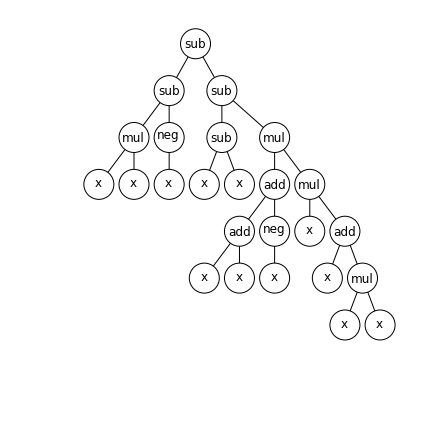

In [16]:
import matplotlib.pyplot as plt
import networkx

nodes, edges, labels = gp.graph(bests[0])
graph = networkx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = networkx.graphviz_layout(graph, prog="dot")

plt.figure(figsize=(7,7))
networkx.draw_networkx_nodes(graph, pos, node_size=900, node_color="w")
networkx.draw_networkx_edges(graph, pos)
networkx.draw_networkx_labels(graph, pos, labels)
plt.axis("off")
plt.show()

The primitives are not limited to standard library operators, any function or instance method can be added to a primitive set. Terminals can be any type of objects and even functions without argument. The next example takes advantage of this flexibility and reduces the runtime of the previous example by vectorizing the evaluation using [Numpy](#numpy), a library of high-level mathematical functions operating on multi-dimensional arrays.

In [17]:
import numpy, random
from deap import algorithms, base, creator, tools, gp

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Tree", gp.PrimitiveTree, fitness=creator.FitnessMin)

pset = gp.PrimitiveSet(name="MAIN", arity=1)
pset.addPrimitive(numpy.add, arity=2)
pset.addPrimitive(numpy.subtract, arity=2)
pset.addPrimitive(numpy.multiply, arity=2)
pset.addPrimitive(numpy.negative, arity=1)

def evaluateRegression(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points)-(points**4 + points**3 + points**2 + points))**2
    return (numpy.sqrt(numpy.sum(sqerrors) / len(points)),)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Tree, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluateRegression, points=numpy.linspace(-1, 1, 1000), pset=pset)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    pop = toolbox.population(n=300)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False)
    print(tools.selBest(pop, k=1)[0])

add(ARG0, multiply(ARG0, add(multiply(ARG0, ARG0), add(negative(multiply(multiply(ARG0, ARG0), negative(ARG0))), ARG0))))


The idea is to evolve a program whose argument is a vector instead of a scalar. Most of the code remains identical; only minor modifications are required. First, we replace the operators in the primitive set by Numpy operators that work on  vectors. Then, we remove the loop from the evaluation function, since it is implicit in the operators. Finally, we replace the `sum` and `sqrt` functions by their faster Numpy equivalent and our regression problem is now vectorized. The execution is thereby significantly improved as the scalar example runs in around 3 seconds to optimize the regression on 20 points, while the vectorial runtime is identical but for a regression on 1000 points. By modifying only 6 lines of code, not only are we able to vectorize our problem, but the runtime is reduced by a **factor 50**!

In addition to the wide support of function and object types, DEAP's *gp* module also supports automatically defined functions (ADF), strongly typed genetic programming (STGP), and object-oriented genetic programming (OOGP), for which examples are provided in the library documentation.

## Distributed Island Model
*This section is skipped because SCOOP cannot run inside a notebook*

## Evolution Support
DEAP comes with several supporting tools that can be easily integrated into any algorithm. This section presents some of them in the context of the OneMax example.

The first tool, *Statistics*, computes statistics on arbitrary attributes of designated objects, usually the fitness individuals. The attribute is specified by a key function at the statistics object instantiation before starting the algorithm.

In [22]:
stats = tools.Statistics(key=operator.attrgetter("fitness.values"))

This is followed by the registration of the statistical functions as for a toolbox.

In [24]:
import numpy
stats.register("max", numpy.max)
stats.register("mean", numpy.mean)
stats.register("min", numpy.min)

Ultimately, at every generation, a statistical record of the population is compiled using the registered functions.

In [25]:
record = stats.compile(pop)
print(record)

{'max': 100.0, 'mean': 98.82333333333334, 'min': 89.0}


The statistics compilation produced a dictionary containing the statistical keywords and their respective value. These last lines, added after the evaluation part, will produce a screen log of the evolution statistics.

For posterity and better readability, statistics can also be logged in a *Logbook*, which is simply a list of recorded dictionaries that can be printed with an elegant layout. For example, the following lines create a new logbook, then record the previously computed statistics and print it to screen.

In [26]:
logbook = tools.Logbook()
logbook.record(gen=0, nevals=300, fitness=record)
print(logbook)

   	      	      fitness      
   	      	-------------------
gen	nevals	max	mean   	min
0  	300   	100	98.8233	89 


The next tool, named *Hall of Fame*, preserves the best individuals that appeared during an evolution. At every generation, it scans the population and saves the individuals in a separate archive that does not interact with the population. If the best solution disappears during the evolution, it will still be available in the hall of fame. The hall of fame can be provided as an argument to the algorithms as follows:

In [27]:
halloffame = tools.HallOfFame(maxsize=10)
pop = toolbox.population(n=300)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,
                                   ngen=40, halloffame=halloffame, verbose=False)

Moreover, the hall of fame can be updated manually right after the population is evaluated with the following line of code.

In [28]:
halloffame.update(pop)

The hall of fame proposes a list interface where the individuals are sorted in descending order of fitness. Thus, the fittest solution can be retrieved by accessing the list's first element.

In [29]:
best = halloffame[0]

A Pareto dominance version of the hall of fame is also available. The *Pareto Front* maintains an archive of non-dominated individuals along the evolution. Its interface is the same than the standard hall of fame.

Another tool, called the *History*, tracks the genealogy of the individuals in a population. By wrapping the variation operators, the history saves the parents of each individual. This feature is added to the variation operators of the toolbox with the following lines.

In [30]:
history = tools.History()
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)

It is therefore possible to determine the genesis of individuals. The next code presents the genealogy of the best individual in the OneMax example for the last 5 generations of the evolution. The graph is produced by the NetworkX library and the following listing.

In [59]:
?networkx.draw_networkx

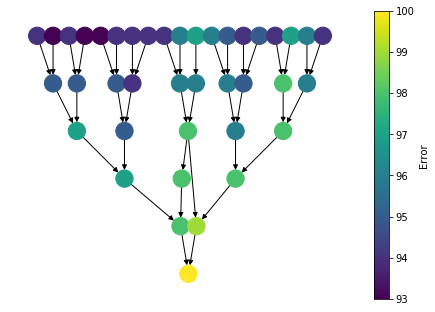

In [62]:
import networkx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
halloffame = tools.HallOfFame(maxsize=1)
pop = toolbox.population(n=300)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,
                                   ngen=40, halloffame=halloffame, verbose=False)

h = history.getGenealogy(halloffame[0], max_depth=5)
graph = networkx.DiGraph(h)
graph = graph.reverse()     # Make the grah top-down
colors = [toolbox.evaluate(history.genealogy_history[i])[0] for i in graph]
pos = graphviz_layout(graph, prog="dot")
networkx.draw(graph, pos, node_color=colors)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                           norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
sm._A = []
cb = plt.colorbar(sm)
cb.set_label("Error")
plt.show()

The last presented tool is a checkpointing facility. Rather than a DEAP object, checkpointing is ensured by the powerful pickle module available in the standard library. Pickle is a module that can serialize almost any Python object. Checkpointing only requires selecting objects that shall be preserved and the write frequency. This is exactly what is done in the following lines that can be added at the end of the generational loop

In [9]:
import pickle

freq = 5
g = 0
if g % freq == 0:
    cp = dict(population=pop, generation=g, rndstate=random.getstate())
    pickle.dump(cp, open("checkpoint.pkl", "wb"), 2)

These last lines write into a file the population, the generation number, and the random number generator state so that this information can be used latter to restart an evolution from this exact point in time.
Reloading the data is as simple as reading the pickled dictionary and accessing its attributes.

In [11]:
cp = pickle.load(open("checkpoint.pkl", "rb"))
pop = cp["population"]
g = cp["generation"]
random.setstate(cp["rndstate"])

This simple mechanism provides fault tolerance to any sort of evolutionary algorithms implemented with DEAP. This happens to be critical when exploiting large computational resources where chances of failure grow quickly with the number of computing nodes. Even in very stable execution environments, checkpoints can significantly reduce the amount of time spent on experimentation by allowing evolutions to restart and continue beyond the original stopping criteria.

## Conclusion
DEAP proposes an agile framework to easily prototype and execute explicit evolutionary algorithms. Its creator module is instrumental for building custom transparent data structures for the problem at hand. Its toolbox gathers all necessary operators and their arguments in a single handy structure. Its design provides straightforward distributed execution with multiple distribution libraries. The presented examples only cover a small part of DEAP's capabilities that include evolution strategies (including CMA-ES), multi-objective optimization (NSGA-II and SPEA-II), co-evolution, particle swarm optimization, as well as many benchmarks (continuous, binary, regression, and moving peaks), and examples (more than 40).

After more than 4 years of development, DEAP version 1.0 has been released in February 2014.
DEAP is an open source software, licensed under LGPL, developed primarily at the Computer Vision and Systems Laboratory of Université Laval, Québec, Canada. DEAP is compatible with Python 2 and 3. It has a single dependency on Numpy for computing statistics and running CMA-ES. Try it out and become nimbler too: <http://deap.gel.ulaval.ca>.

## References

- <a id="deap-jmlr">[1]</a> F.-A. Fortin, F.-M. De Rainville, M.-A. Gardner, M. Parizeau, and C. Gagné.
DEAP: Evolutionary Algorithms Made Easy.
*Journal of Machine Learning Research*,
13:2171--2175, 2012.

- <a id="deap-gecco">[2]</a> F.-M. De Rainville, F.-A. Fortin, M.-A. Gardner, M. Parizeau, and C. Gagné.
DEAP: A Python Framework for Evolutionary Algorithms. 
*In Companion Proceedings of the Genetic and Evolutionary Computation Conference*,
pages 85--92, 2012.

- <a id="scoop">[3]</a> Y. Hold-Geoffroy, O. Gagnon, and M. Parizeau.
SCOOP: Scalable COncurrent Operations in Python.
<http://www.pyscoop.org/>

- <a id="koza">[4]</a> J. R. Koza.
Genetic Programming - On the Programming of Computers by Means of Natural Selection.
MIT Press, 1992.

- <a id="networkx">[5]</a> A. A. Hagberg, D. A. Schult, and P. J. Swart. 
Exploring network structure, dynamics, and function using NetworkX.
*In Proceedings of the Python in Science Conference*,
pages 11-15, 2008.
<http://networkx.github.io>

- <a id="pygraphviz">[6]</a> A. A. Hagberg, D. A. Schult, and M. Renieris.
PyGraphviz a Python interface to the Graphviz graph layout and visualization package.
<http://networkx.lanl.gov/pygraphviz>

- <a id="numpy">[7]</a> E. Jones and T. Oliphant and P. Peterson and others.
SciPy: Open source scientific tools for Python.
<http://www.scipy.org>